In [ ]:
# @inproceedings{barbieri-etal-2020-tweeteval,
#     title = "{T}weet{E}val: Unified Benchmark and Comparative Evaluation for Tweet Classification",
#     author = "Barbieri, Francesco  and
#       Camacho-Collados, Jose  and
#       Espinosa Anke, Luis  and
#       Neves, Leonardo",
#     booktitle = "Findings of the Association for Computational Linguistics: EMNLP 2020",
#     month = nov,
#     year = "2020",
#     address = "Online",
#     publisher = "Association for Computational Linguistics",
#     url = "https://aclanthology.org/2020.findings-emnlp.148",
#     doi = "10.18653/v1/2020.findings-emnlp.148",
#     pages = "1644--1650"
# }

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict


import tensorflow as tf
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification

from sklearn.feature_extraction.text import TfidfVectorizer

/home/hugohdezm/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-01-07 17:55:09.928725: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736272509.937614   21079 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736272509.940184   21079 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-07 17:55:09.949645: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performanc

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
# dataset = pd.read_csv('out3.csv')
# dataset

train_data = pd.read_csv('train.csv')
validation_data = pd.read_csv('validation.csv')
test_data = pd.read_csv('test.csv')

print(train_data.shape)
print(validation_data.shape)
print(test_data.shape)

(64112, 2)
(8014, 2)
(4453, 2)


In [ ]:
print(train_data.head())
print(validation_data.head())
print(test_data.head())

                                                text  labels
0                              That's [NAME] for ya'       4
1  Huh. Similar things happen to me. Just my big ...       6
2                        This guy sports entertains.       3
3  Nailed it all I do is giving words but all you...       4
4  Because real socialism is fawning over rich ca...       4
                                                text  labels
0  And when guys your age are getting to be too o...       4
1  No seriously, the is a Java.net library. part ...       4
2  “My Girlfriend, [NAME] has returned! Greetings...       3
3  Source each of these and trend lines from prev...       0
4                           Sounds like a great chap       3
                                                text  labels
0   Then let's leave society and start a better one.       4
1  I agree. I’d love to keep [NAME] around but re...       3
2  No problem here, as long as neither one of you...       0
3  Well someone posted t

In [ ]:
train_dataset = Dataset.from_pandas(train_data)
validation_dataset = Dataset.from_pandas(validation_data)
test_dataset = Dataset.from_pandas(test_data)

huggingface_dataset = DatasetDict({
    'train': train_dataset,
    'validation': validation_dataset,
    'test': test_dataset
})

huggingface_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'labels'],
        num_rows: 64112
    })
    validation: Dataset({
        features: ['text', 'labels'],
        num_rows: 8014
    })
    test: Dataset({
        features: ['text', 'labels'],
        num_rows: 4453
    })
})

In [ ]:
checkpoint = 'cardiffnlp/twitter-roberta-base'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenize_function(examples):
    return tokenizer(examples['text'], padding='max_length', truncation=True, max_length=512)

tokenized_datasets = huggingface_dataset.map(tokenize_function, batched=True)
tokenized_datasets.column_names

Map: 100%|██████████| 4453/4453 [00:00<00:00, 14939.97 examples/s]


{'train': ['text', 'labels', 'input_ids', 'attention_mask'],
 'validation': ['text', 'labels', 'input_ids', 'attention_mask'],
 'test': ['text', 'labels', 'input_ids', 'attention_mask']}

In [ ]:
tokenized_datasets = tokenized_datasets.remove_columns(['text'])
tokenized_datasets = tokenized_datasets.with_format('tensorflow')
tokenized_datasets['train']

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 64112
})

In [ ]:
train_dataset = tokenized_datasets['train'].to_tf_dataset(
    columns=['input_ids', 'attention_mask',],
    label_cols=['labels'],
    shuffle=True,
    batch_size=10)

validation_dataset = tokenized_datasets['validation'].to_tf_dataset(
    columns=['input_ids', 'attention_mask'],
    label_cols=['labels'],
    shuffle=True,
    batch_size=10)

test_dataset = tokenized_datasets['test'].to_tf_dataset(
columns=['input_ids', 'attention_mask'],
label_cols=['labels'],
shuffle=False,
batch_size=10)

/home/hugohdezm/miniconda3/envs/tf_gpu/lib/python3.10/site-packages/datasets/arrow_dataset.py:403: FutureWarning: The output of `to_tf_dataset` will change when a passing single element list for `labels` or `columns` in the next datasets version. To return a tuple structure rather than dict, pass a single string.
Old behaviour: columns=['a'], labels=['labels'] -> (tf.Tensor, tf.Tensor)  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor)  
New behaviour: columns=['a'],labels=['labels'] -> ({'a': tf.Tensor}, {'labels': tf.Tensor})  
             : columns='a', labels='labels' -> (tf.Tensor, tf.Tensor) 
  warnings.warn(
I0000 00:00:1736272788.150968   21079 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12728 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:01:00.0, compute capability: 8.9


In [ ]:
import transformers
from transformers import AdamWeightDecay

checkpoint = 'cardiffnlp/twitter-roberta-base'
model = TFAutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=7)

num_epochs = 3
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optimizer = AdamWeightDecay(learning_rate=2e-5, weight_decay_rate=0.01)

model.compile(optimizer=optimizer, loss=loss, metrics=['sparse_categorical_accuracy'])

All model checkpoint layers were used when initializing TFRobertaForSequenceClassification.

Some layers of TFRobertaForSequenceClassification were not initialized from the model checkpoint at cardiffnlp/twitter-roberta-base and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
history = model.fit(
  train_dataset,
  validation_data=validation_dataset,
  epochs=num_epochs,
  steps_per_epoch=len(train_dataset),
  validation_steps=len(validation_dataset)
)

Epoch 1/3
6412/6412 [==============================] - 4280s 666ms/step - loss: 0.8151 - sparse_categorical_accuracy: 0.6960 - val_loss: 0.8111 - val_sparse_categorical_accuracy: 0.6841
Epoch 2/3
6412/6412 [==============================] - 4263s 665ms/step - loss: 0.5149 - sparse_categorical_accuracy: 0.8154 - val_loss: 0.9575 - val_sparse_categorical_accuracy: 0.6968
Epoch 3/3
6412/6412 [==============================] - 4331s 676ms/step - loss: 0.2736 - sparse_categorical_accuracy: 0.9044 - val_loss: 1.2512 - val_sparse_categorical_accuracy: 0.6705


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


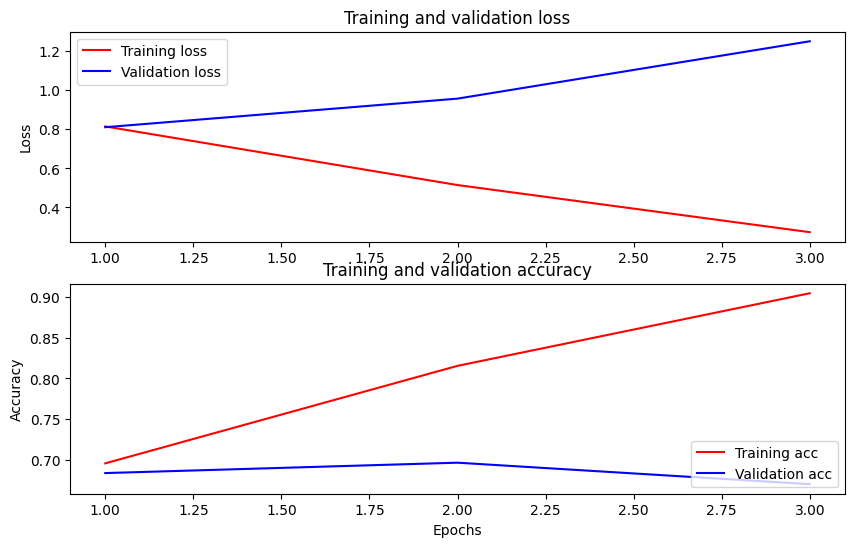

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
dataset_name = 'feelnet-ROBERTA-3-augmented-2'
saved_model_path = './{}_huggingface'.format(dataset_name.replace('/', '_'))

model.save(saved_model_path, include_optimizer=True)

INFO:tensorflow:Assets written to: ./feelnet-ROBERTA-3-augmented-2_huggingface/assets


INFO:tensorflow:Assets written to: ./feelnet-ROBERTA-3-augmented-2_huggingface/assets


In [ ]:
model.save_pretrained('./roberta_3_augmented-2_finetuned_model')
tokenizer.save_pretrained('./roberta_3_augmented-2_finetuned_model')

('./roberta_3_augmented-2_finetuned_model/tokenizer_config.json',
 './roberta_3_augmented-2_finetuned_model/special_tokens_map.json',
 './roberta_3_augmented-2_finetuned_model/vocab.json',
 './roberta_3_augmented-2_finetuned_model/merges.txt',
 './roberta_3_augmented-2_finetuned_model/added_tokens.json',
 './roberta_3_augmented-2_finetuned_model/tokenizer.json')

In [ ]:
print(saved_model_path)

./feelnet-ROBERTA-3-augmented-2_huggingface


In [ ]:
## Recuperar el modelo guardado con model.save
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
## Recuperar el modelo guardado con save_pretrained
reloaded_tokenizer = AutoTokenizer.from_pretrained('./roberta_3_augmented-1_finetuned_model')
reloaded_model = TFAutoModelForSequenceClassification.from_pretrained('./roberta_3_augmented-1_finetuned_model')